# Research Methodology (Week 8)

In [67]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV
import numpy as np
import pandas as pd
import os
import seaborn as sns
import warnings

# Experimental Algorithm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Gradient extreme gradient boosted trees
from xgboost import XGBRegressor

In [18]:
warnings.filterwarnings('ignore')
sns.set_theme()

<br/>

In [99]:

# Helper function to generate the dataset

def create_dataset(data_dir='training', patient=None): 
    """
    Generate training and test sets based on the 17 features selected from week 6. These 
    include all features with a correlation > 0.15 with the BIS.
    
    
    Parameters
    -----------
    data_dir : {"training", "test"}, default = 'training'
        Create the training or test dataset based on the selected features.
        
    patient : String, default=None
        Create the dataset of a patient. It depends on data_dir parameter i.e. if the
        data_dir is set to 'training', then the patient must be present in the training set,
        otherwise, the patient must be present in the test set.
        
        If None, the dataset of the patient is NOT created.
        
        
    Returns
    --------
    dataset: pd.DataFrame
        The training, test, or patient dataset.
    """
    
    folders = ["SampEntropy_CH2Squared", "Katz_CH2Squared", "SampEntropy", "Katz", "SampEntropy_CH2DenoisedSquared", "Katz_CH2DenoisedSquared", "PermEntropy_CH2DenoisedSquared", "Higuchi_CH2DenoisedSquared"]
    patient_dict = {}
    
    if data_dir == 'training':
        directory = 'Class A train sets'
        
    if data_dir == 'test':
        directory = 'Class B test sets'
        

    for folder in folders:
        if patient == None:
            # Creating the entire dataset using the data.csv files
            df = pd.read_csv("./{}/{}/Modified/data.csv".format(directory, folder))
            
        if patient != None:
            # Creating datasets for each patient
            try:
                df = pd.read_csv("./{}/{}/Modified/{}".format(directory, folder, patient+'_modified.csv'))
                
            except FileNotFoundError:
                print("Patient {} does not exist in the {} set.".format(patient, data_dir))
                return
                

        patient_dict['BIS'] = df['BIS']

        # CH2^2 Folder
        if folder == "Katz_CH2Squared":
            patient_dict['Katz_cA_4'] = df['Katz_cA_4']
            patient_dict['Katz_cD_2'] = df['Katz_cD_2']
            
        if folder == "SampEntropy_CH2Squared":
            patient_dict['SampenCA_4'] = df['SampenCA_4']
            patient_dict['SampenCD_2'] = df['SampenCD_2']
            
        

        # CH2Denoised Folders
        if folder ==  "SampEntropy":
            patient_dict['SampenCD_2D'] = df['SampenCD_2']
            patient_dict['SampenCA_4D'] = df['SampenCA_4']

        if folder ==  "Katz":
            patient_dict['Katz_cD_2D'] = df['Katz_cD_2']
            patient_dict['Katz_cA_4D'] = df['Katz_cA_4']



        # CH2DenoisedSquared Folders
        if folder == "SampEntropy_CH2DenoisedSquared":
            patient_dict['SampenCA_4DS'] = df['SampenCA_4']
            patient_dict['SampenCD_2DS'] = df['SampenCD_2']


        if folder == "Katz_CH2DenoisedSquared":
            patient_dict['Katz_DeltaDS'] = df['Katz_Delta']
            patient_dict['Katz_cD_1DS'] = df['Katz_cD_1']
            patient_dict['Katz_cA_4DS'] = df['Katz_cA_4']
            


        if folder == "PermEntropy_CH2DenoisedSquared":
            patient_dict['Permen_cD_1DS'] = df['Permen_cD_1']
            patient_dict['Permen_cD_3DS'] = df['Permen_cD_3']
            patient_dict['Permen_GammaDS'] = df['Permen_Gamma']


        if folder == "Higuchi_CH2DenoisedSquared":
            patient_dict['Hig_cA_4DS'] = df['Hig_cA_4']
            
            
    dataset = pd.DataFrame(patient_dict)
    
    return dataset

<br/>

<br/>

<div style="border: 2px solid #656565; border-radius: 5px; padding: 2rem 3rem;">
    <h1 style="margin: 0; color: #343d52">Model Building</h1>
</div>

In [108]:
training_df = pd.read_csv("training_set.csv")
training_df.head()

,BIS,SampenCA_4,SampenCD_2,Katz_cA_4,Katz_cD_2,SampenCD_2D,SampenCA_4D,Katz_cD_2D,Katz_cA_4D,SampenCA_4DS,SampenCD_2DS,Katz_DeltaDS,Katz_cD_1DS,Katz_cA_4DS,Permen_cD_1DS,Permen_cD_3DS,Permen_GammaDS,Hig_cA_4DS
0,95.8,1.118584,1.589795,2.579210,3.842405,0.295259,0.376660,2.220077,2.975620,0.308904,0.176011,1.891554,1.815630,1.847512,0.997721,0.992431,0.993749,1.812455
1,95.8,1.108791,1.578562,2.427762,3.855503,0.317506,0.404385,2.231705,2.945514,0.319252,0.182602,1.886988,1.818783,1.855281,0.997555,0.993881,0.993224,1.812594
2,95.8,1.111692,1.567324,2.581948,3.533784,0.342623,0.442947,2.239327,2.975240,0.328542,0.187470,1.888266,1.821905,1.858956,0.997616,0.994908,0.992231,1.810743
3,95.6,1.122940,1.594337,2.260806,3.837354,0.371085,0.492027,2.246107,2.976338,0.340638,0.192986,1.883636,1.823571,1.862032,0.998204,0.996844,0.991169,1.810351
4,95.6,1.091586,1.622987,2.301977,3.401760,0.403649,0.552274,2.251073,2.993204,0.337477,0.196044,1.882063,1.824643,1.863008,0.998105,0.998060,0.990647,1.808214


<br/>

## Feature Selection

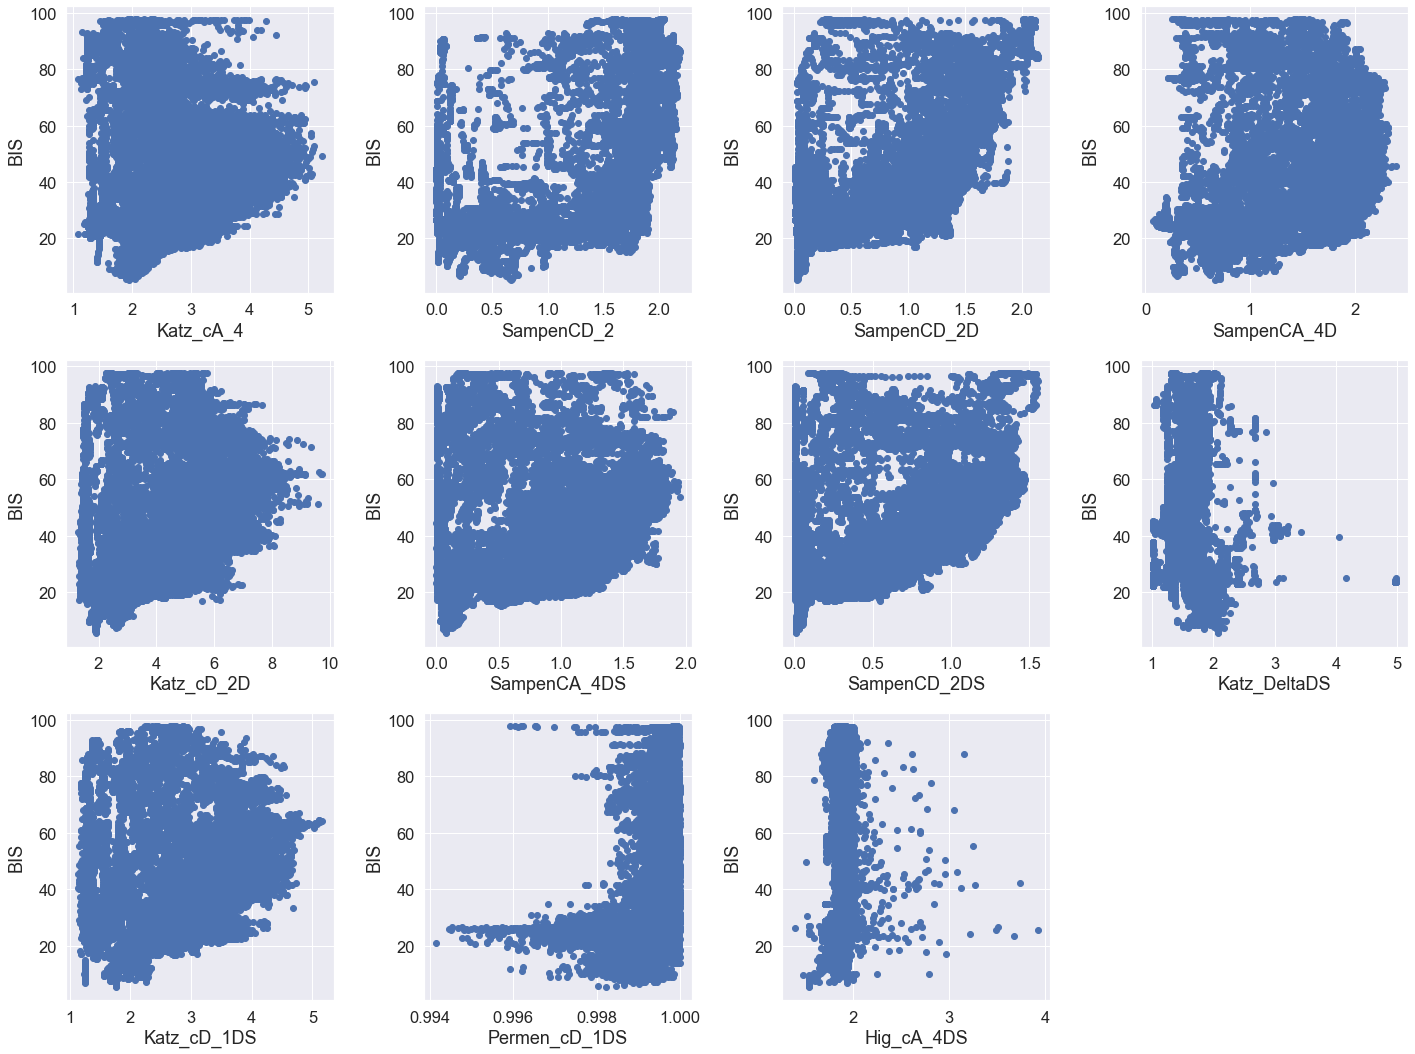

In [23]:
# Selected features
cols = ['Katz_cA_4', 'SampenCD_2', 'SampenCD_2D', 'SampenCA_4D', 'Katz_cD_2D', 'SampenCA_4DS', 'SampenCD_2DS', 'Katz_DeltaDS', 'Katz_cD_1DS', 'Permen_cD_1DS', 'Hig_cA_4DS']


# Check the relationship between the selected features and the BIS
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

ax[2, 3].axis('off')

for idx, feature in enumerate(cols[:4]):
    ax[0, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[0, idx].set_ylabel('BIS')
    ax[0, idx].set_xlabel(feature)
    
for idx, feature in enumerate(cols[4:8]):
    ax[1, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[1, idx].set_ylabel('BIS')
    ax[1, idx].set_xlabel(feature)
    
for idx, feature in enumerate(cols[8:]):
    ax[2, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[2, idx].set_ylabel('BIS')
    ax[2, idx].set_xlabel(feature)
    
    
plt.tight_layout()
plt.show()

<br/>

## Selected Features

In [58]:
# Removed Hig_cA_4DS, Permen_cD_1DS, Katz_DeltaDS, SampenCD_2
selected_features = ['Katz_cA_4', 'SampenCD_2D', 'SampenCA_4D', 'Katz_cD_2D', 'SampenCA_4DS', 'SampenCD_2DS', 'Katz_cD_1DS']

print("FINAL SELECTED FEATURES \n\n{}".format(selected_features))

FINAL SELECTED FEATURES 

['Katz_cA_4', 'SampenCD_2D', 'SampenCA_4D', 'Katz_cD_2D', 'SampenCA_4DS', 'SampenCD_2DS', 'Katz_cD_1DS']


<br/>

<br/>

<hr>

# Model Selection and Evaluation

Sebastian discussed how to use *k*-fold cross validation for model selection. So I implemented his ideas. The key idea is keep a separate and independent test set at bay, while we try to model our data with various algorithms. **This is done to avoid the leaking of test data in the training stage**. In addition, I also used GridSearch to find optimum model parameters for each model.

<img src="Model Building.png" />

*Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning* (Sebastian Raschka, 2018)

In [126]:
class model:
    
    my_model = None

    def __init__(self, model, data, scale):
        self.model = model
        self.data = data
        self.scale = scale        
            
            
    # Model Selection
    def fit(self, features):
        X = self.data[features]
        y = self.data['BIS']
        
        if self.scale == True:
            scaled_X = StandardScaler()
            scaled_Y = StandardScaler()

            X = scaled_X.fit_transform(X)
            y = scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
            
            
        # Ridge regression
        # Param Grid: [{'alpha': param_range}]
        if self.model == 'rr':
            my_model = Ridge()
            my_model.fit(X, y)
            self.my_model = my_model
            
            
            
        # Histogram-based Gradient boosting tree (Experimental)
        # Param Grid: [{max_depth: [100, 110, 120, 130, 140]}]
        if self.model == 'hist_r':
            my_model = HistGradientBoostingRegressor()
            my_model.fit(X, y)
            self.my_model = my_model
            

        
        # Extreme Gradient boosted trees
        # Param Grid: [{'n_estimators': [1000, 1500, 2000], 
        #               'max_depth': [7, 8, 9, 10], 
        #               'gamma': [0, 1, 2, 3, 4, 5]}]
        if self.model == "xgboost":
            my_model = XGBRegressor(n_estimators=1000, max_depth=10, gamma=3)
            my_model.fit(X, y)
            self.my_model = my_model

        
        # ---------------
        # FOR EVALUATION
        # ---------------
        # Perform GridSearch to find the best model
#         cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
#         gs = GridSearchCV(my_model, param_grid=self.params, scoring='r2', cv=cv, n_jobs=-1)
#         gs.fit(X, y)



        # Metrics of the best model
#         print('Best R^2: {}'.format(gs.best_score_))
#         print('Best parameters: \n{}'.format(gs.best_params_))


        # Fit the best model on the training set
#         best_model = gs.best_estimator_
#         best_model.fit(X, y)
#         self.my_model = best_model




        

            
    # Predict for training or test set
    def predict(self, test_data, features, visualize=True, evaluate=True):
        
        if self.my_model == None:
            raise Exception("Call the fit() method to train a model")
            
        X = test_data[features]
        y = test_data['BIS']
        xmin, xmax = 0, 110
        
        if self.scale == True:
            test_scaled_X = StandardScaler()
            test_scaled_Y = StandardScaler()
            
            X = test_scaled_X.fit_transform(X)
            y = test_scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
            # For the residual plot
            xmin, xmax = -3, 3
            
            
        # Predict
        y_pred = self.my_model.predict(X)
            
        # Visualize after predicting    
        if visualize == True:
            figure = plt.figure(figsize=(15, 10))
            plt.plot(y, label="Actual BIS")
            plt.plot(y_pred, label="Predicted BIS")
            plt.xlabel('Samples')
            plt.ylabel('BIS')
            plt.legend(loc='upper left')
            plt.title("Depth of Anaesthesia assessment with EEG")
            plt.show()
            
            
        if evaluate == True:
            # Residual plot
            figure = plt.figure(figsize=(15, 10))
            plt.scatter(y_pred, y_pred - y, c='royalblue', marker='o',  edgecolor='white')
            plt.ylabel("Residuals")
            plt.xlabel("Predicted Values")
            plt.hlines(y=0, xmin=xmin, xmax=xmax, color='black', lw=2)
            plt.xlim([xmin, xmax])
            plt.show()
            
            
            # MSE and R^2
            mse = mean_squared_error(y, y_pred)
            
            print("MSE: %.3f" % mse)

                
                
        
            

In [110]:
# Training a linear regression model on the alpha dataset
test_model = model('lr', training_df, scale=False)

test_model.fit(selected_features)

Done training


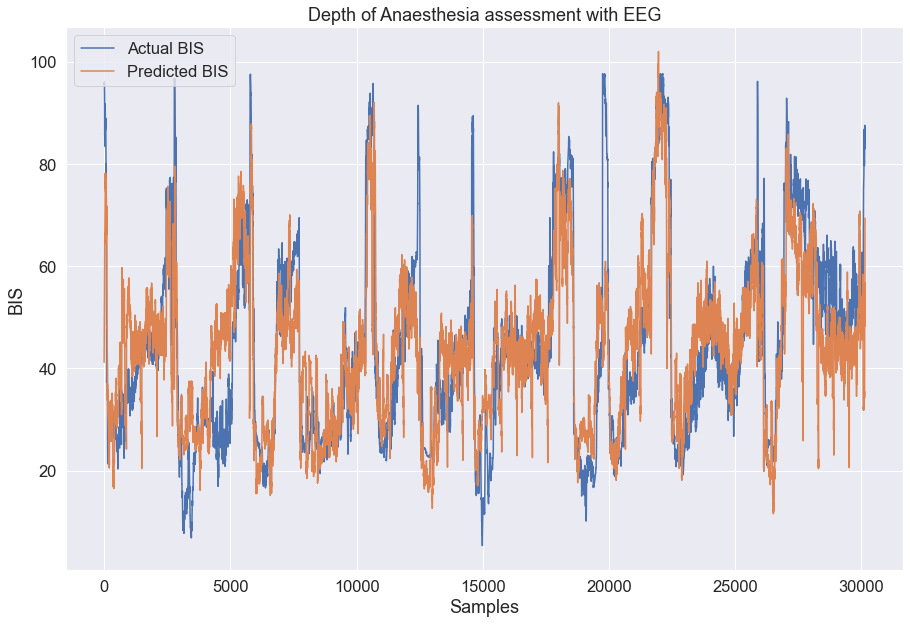

In [112]:
# Testing on the original training set
test_model.predict(training_df, selected_features, evaluate=False)

<br/>

<br/>

## Patient files

In [115]:
# Training set (The patients)
training_set = [file for file in os.listdir("./Class A train sets") if ".mat" in file]

<br/>

## <code>Ridge Regression</code>

In [131]:
# Create a linear regression model using the entire training dataset
rr = model('rr', training_df, scale=False)

# Train the model
rr.fit(selected_features)

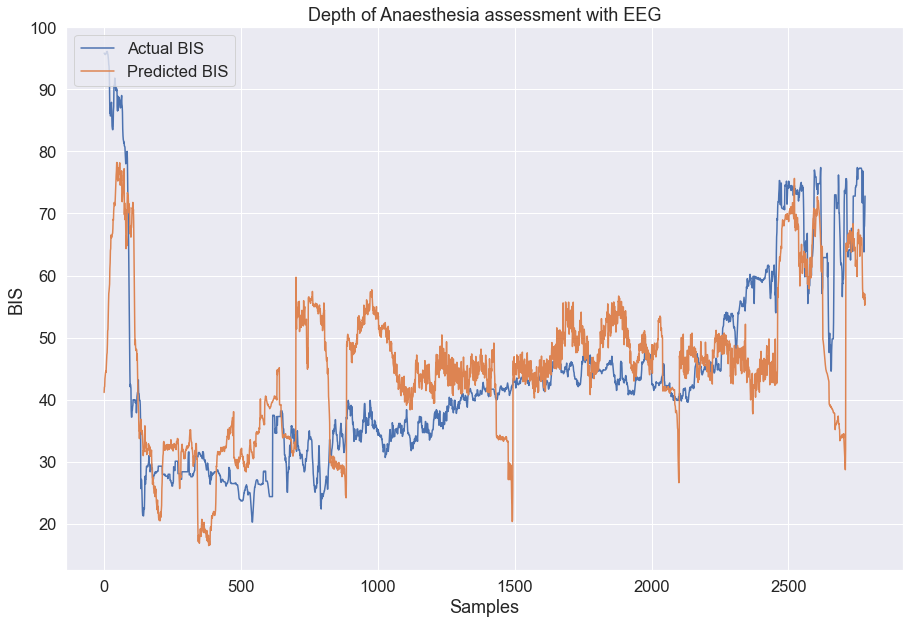

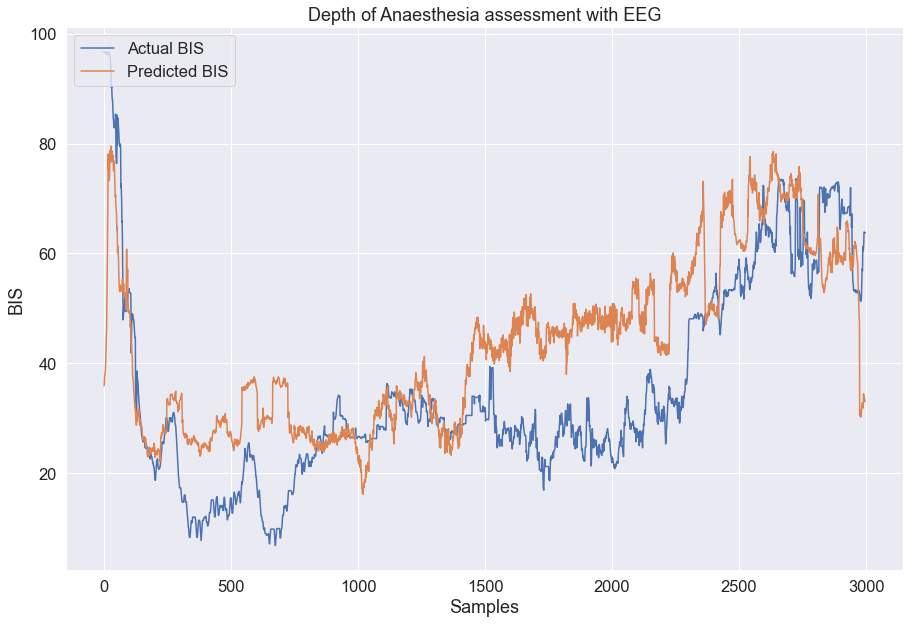

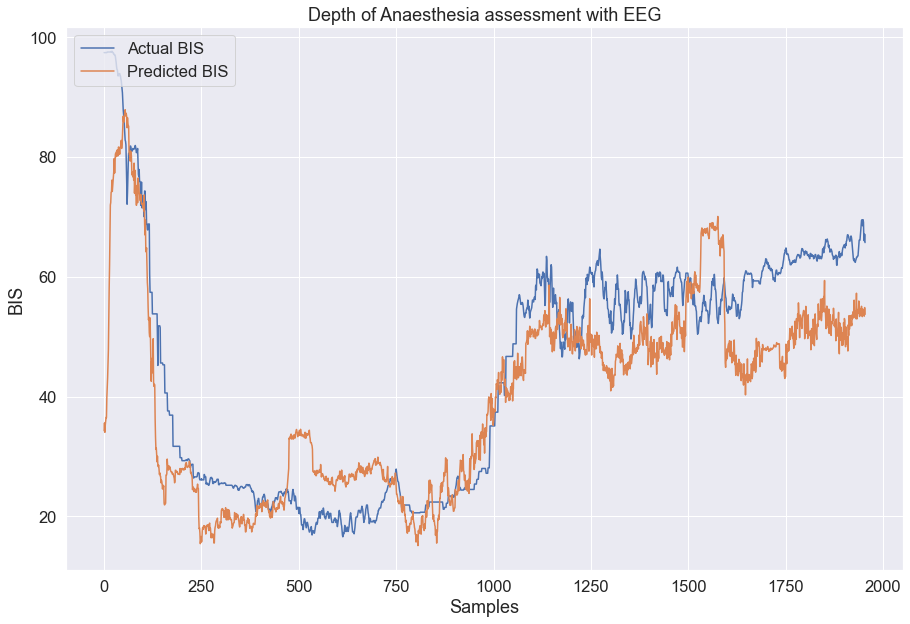

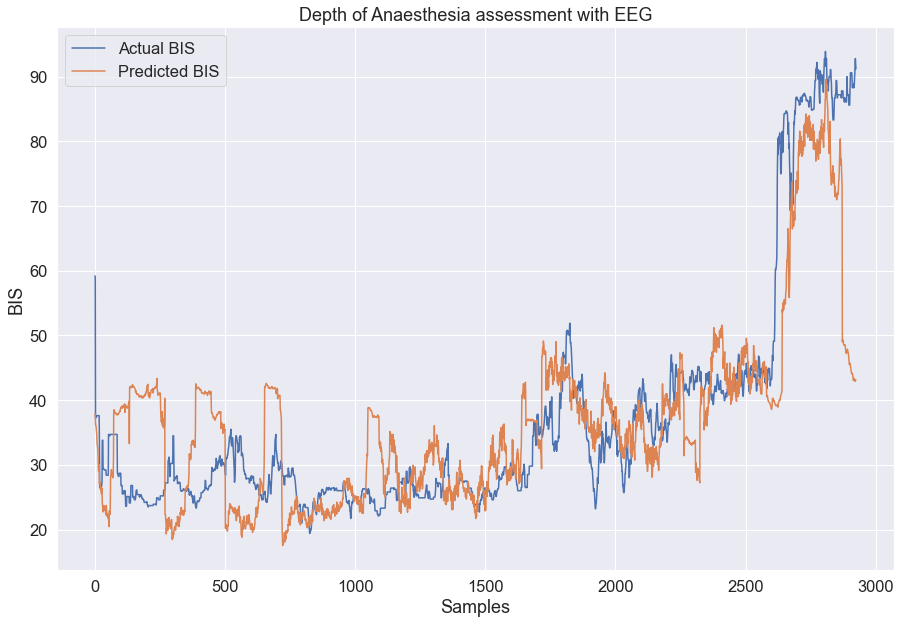

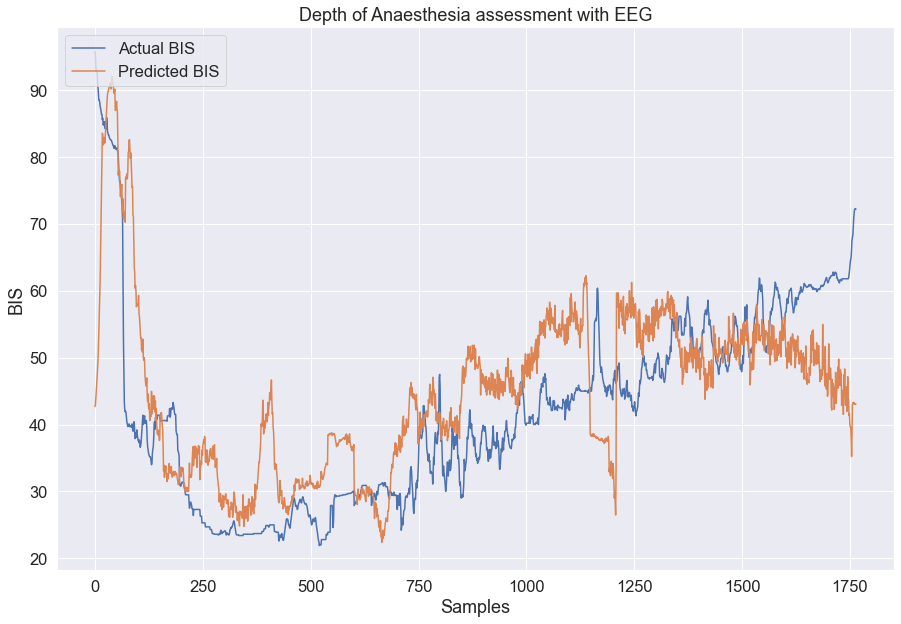

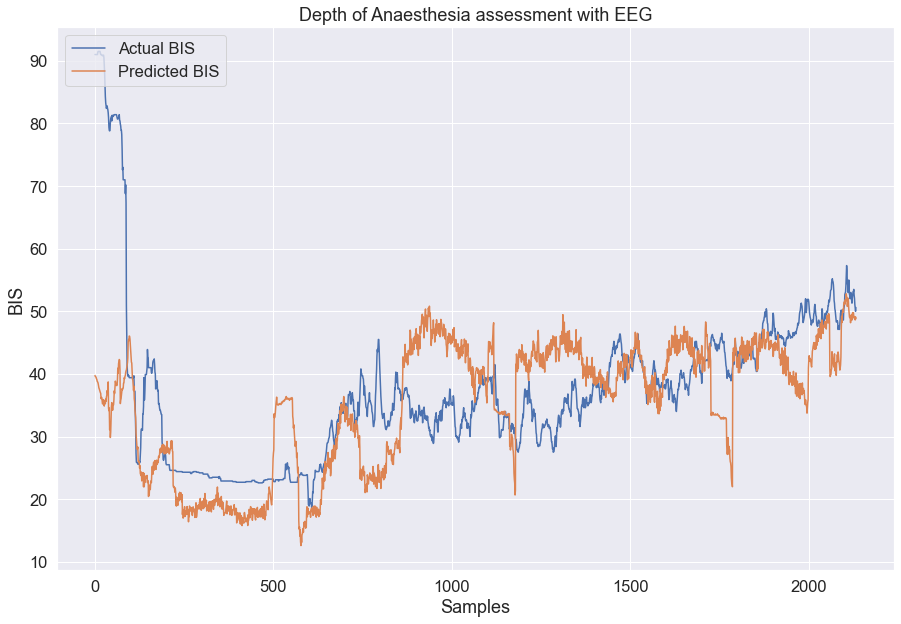

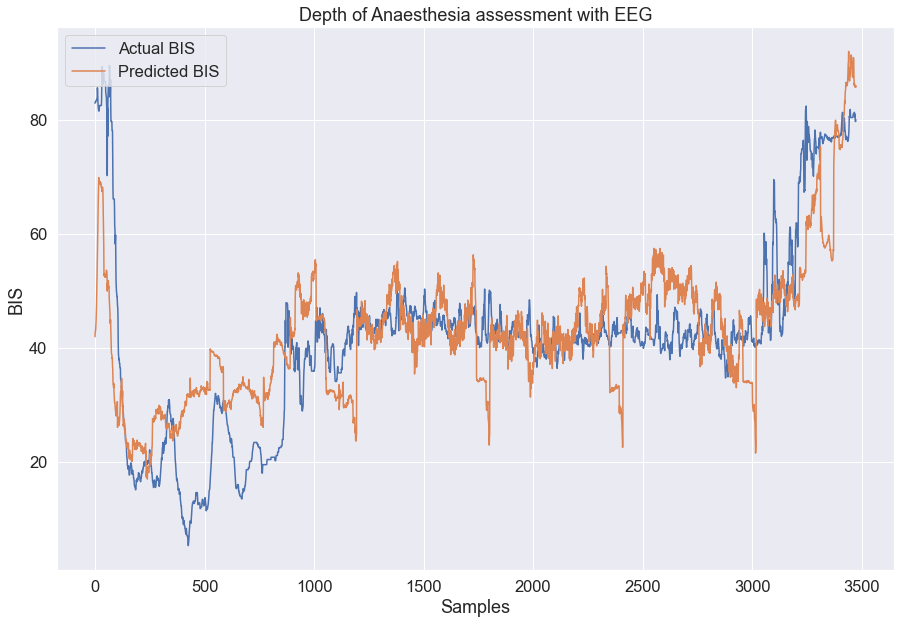

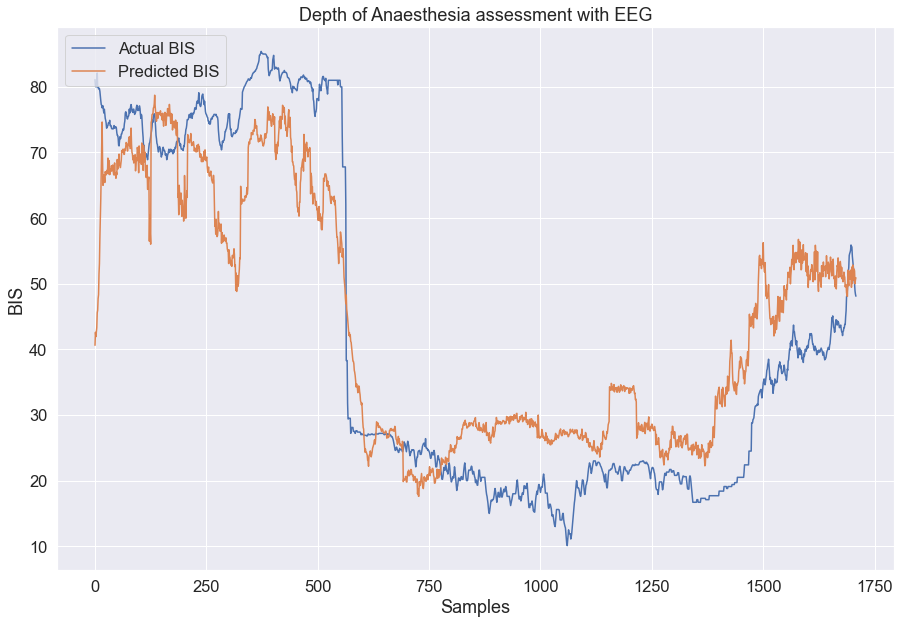

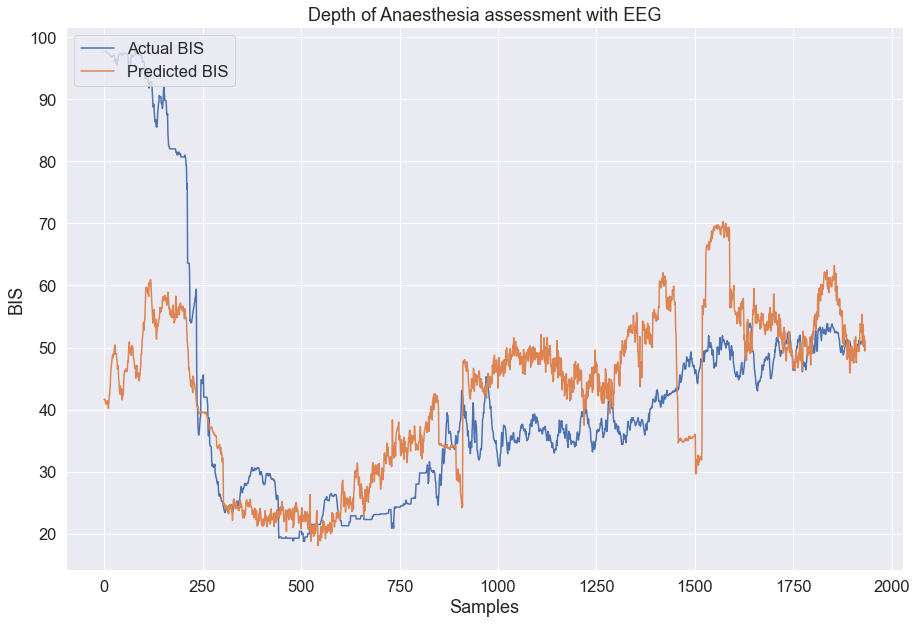

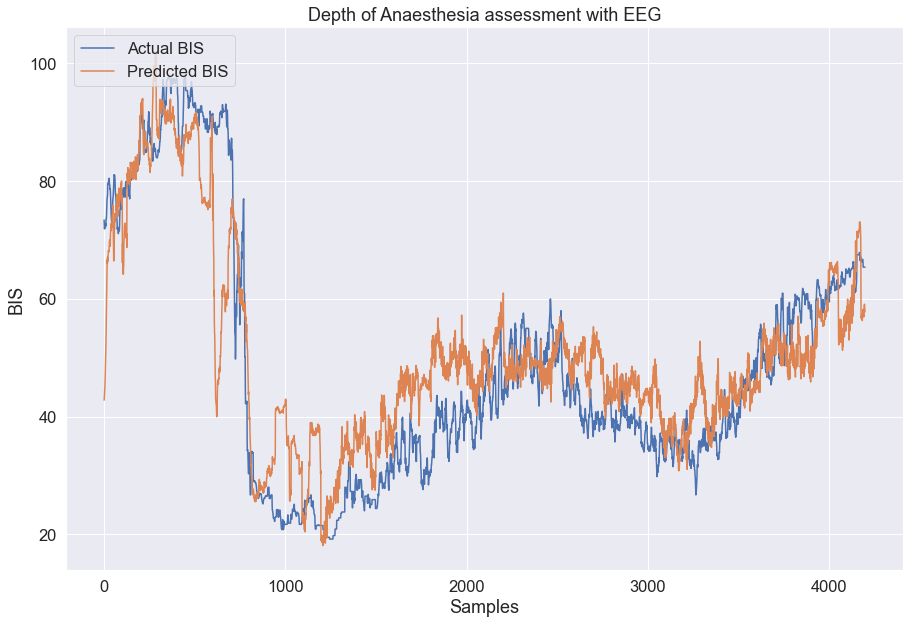

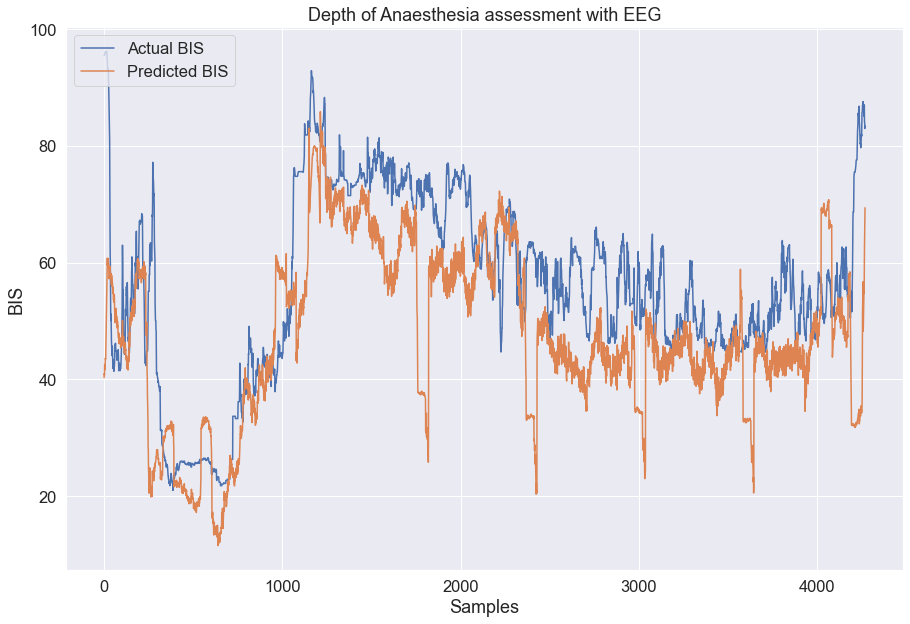

In [132]:
for train in training_set:
    patient = create_dataset(patient=train)
    rr.predict(patient, selected_features, evaluate=False)

<br/>

<br/>

## <code>XG Boost Regression</code>

In [123]:
# Create a linear regression model using the entire training dataset
xg_boost = model('xgboost', training_df, scale=False)

# Train the model
xg_boost.fit(selected_features)

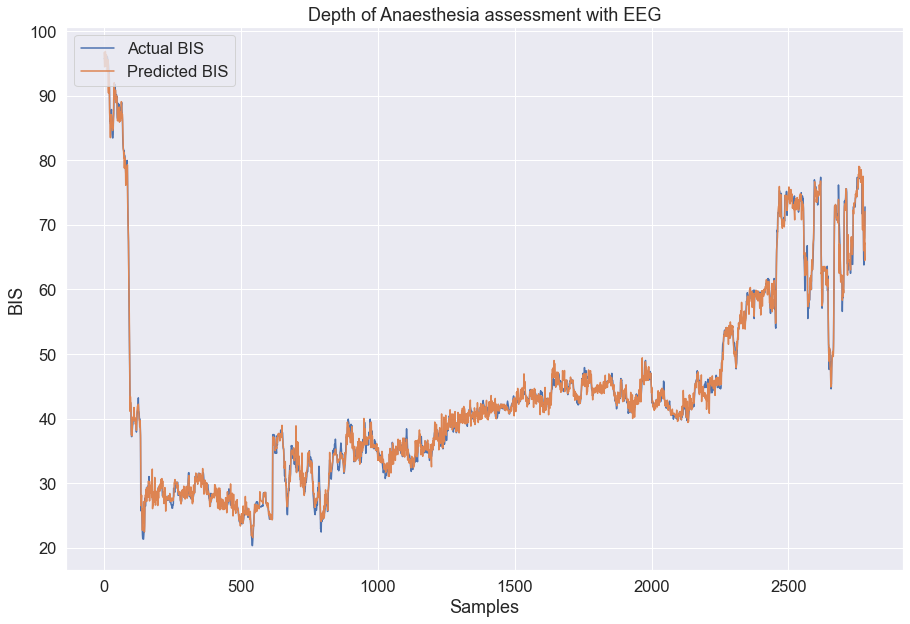

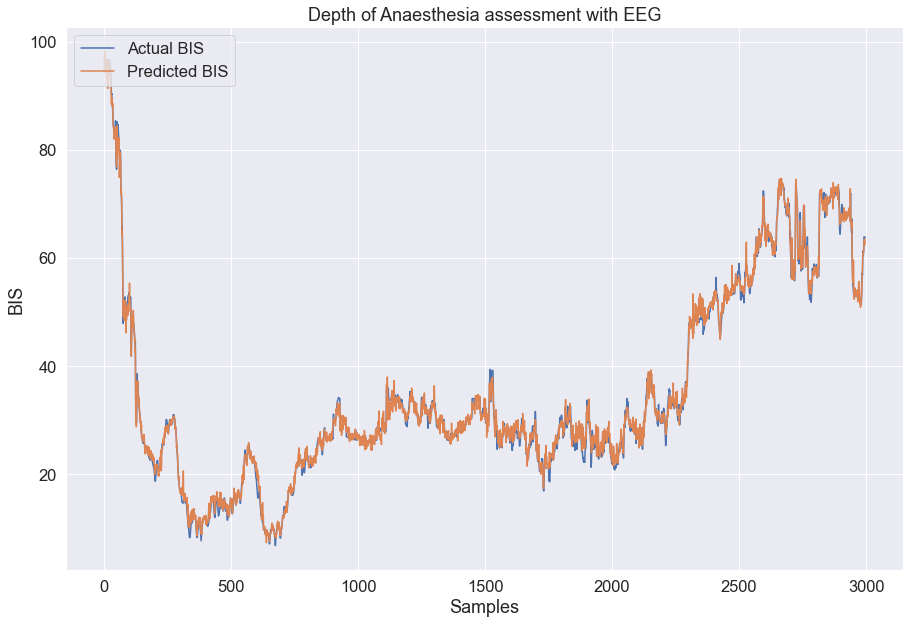

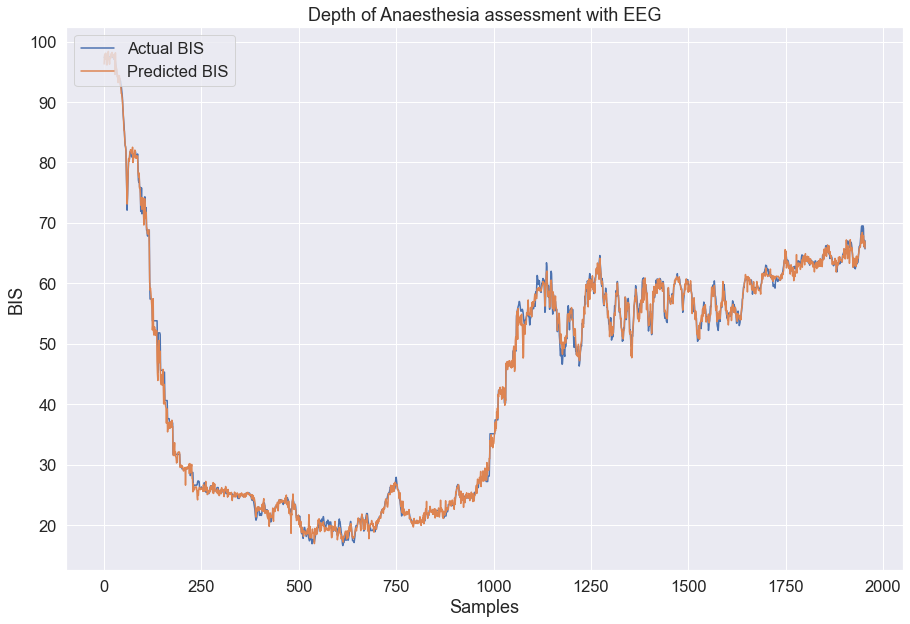

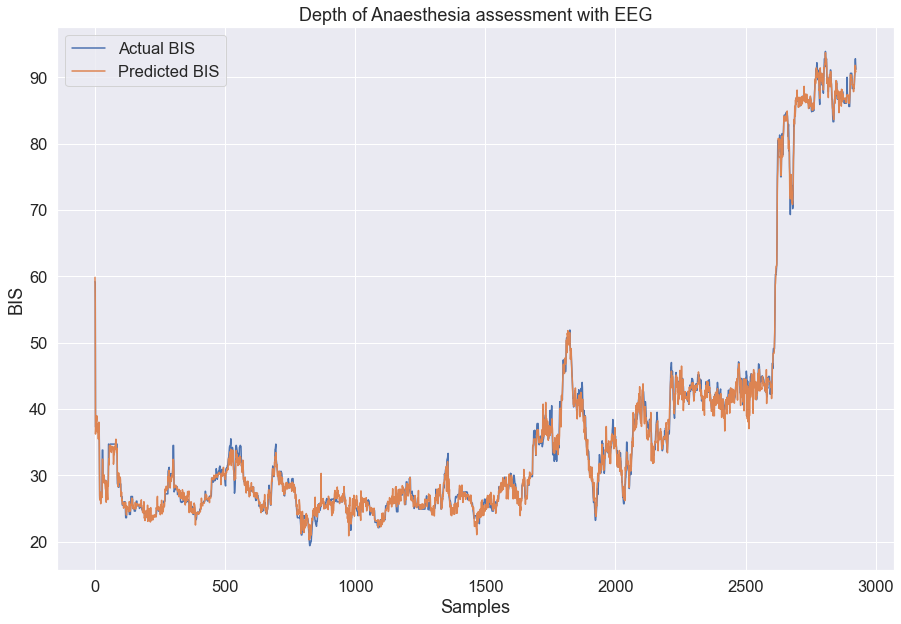

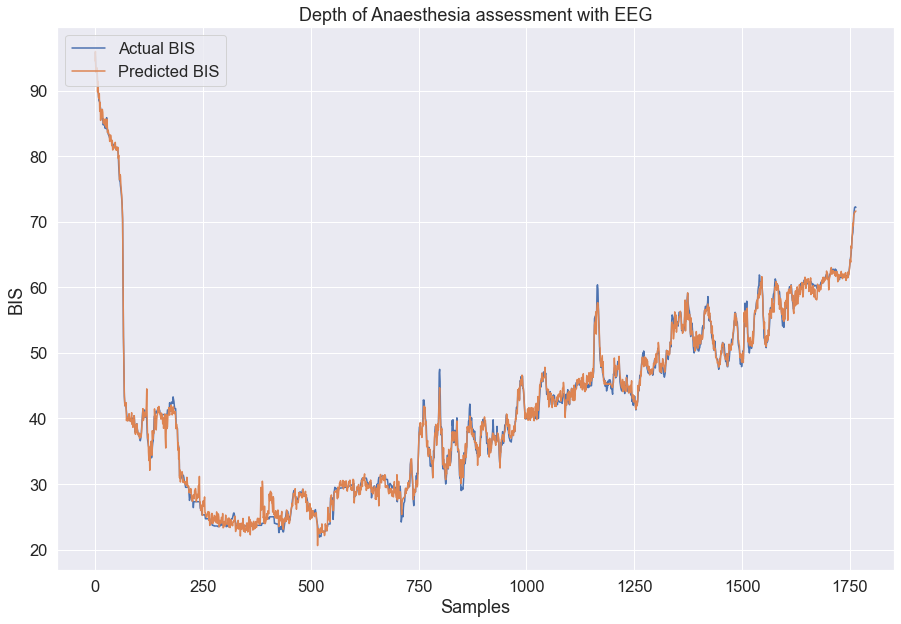

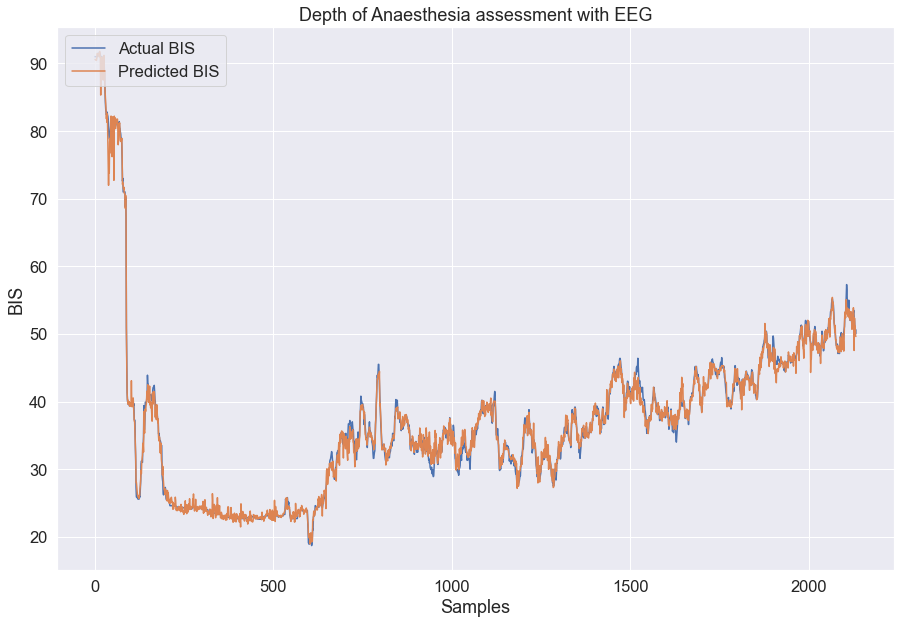

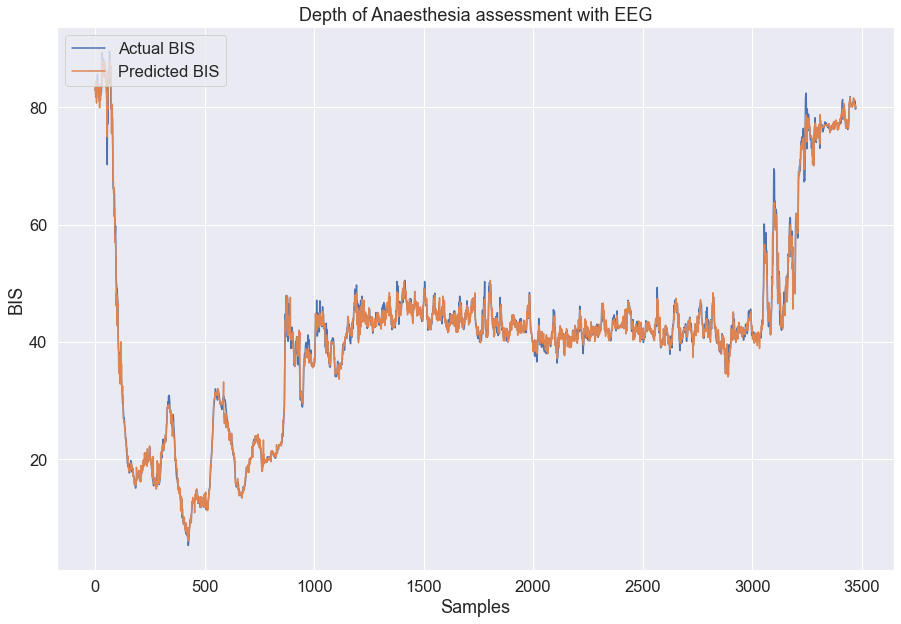

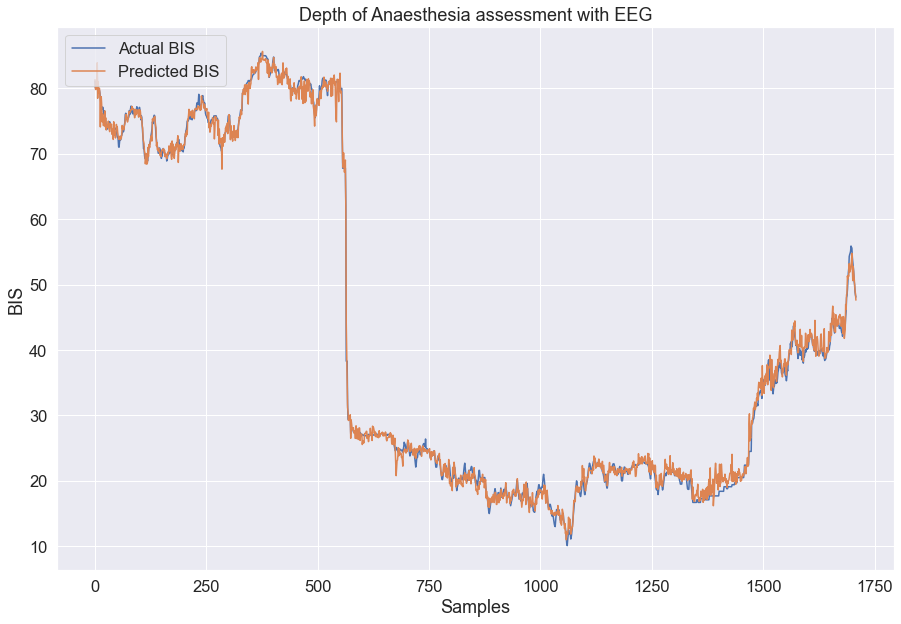

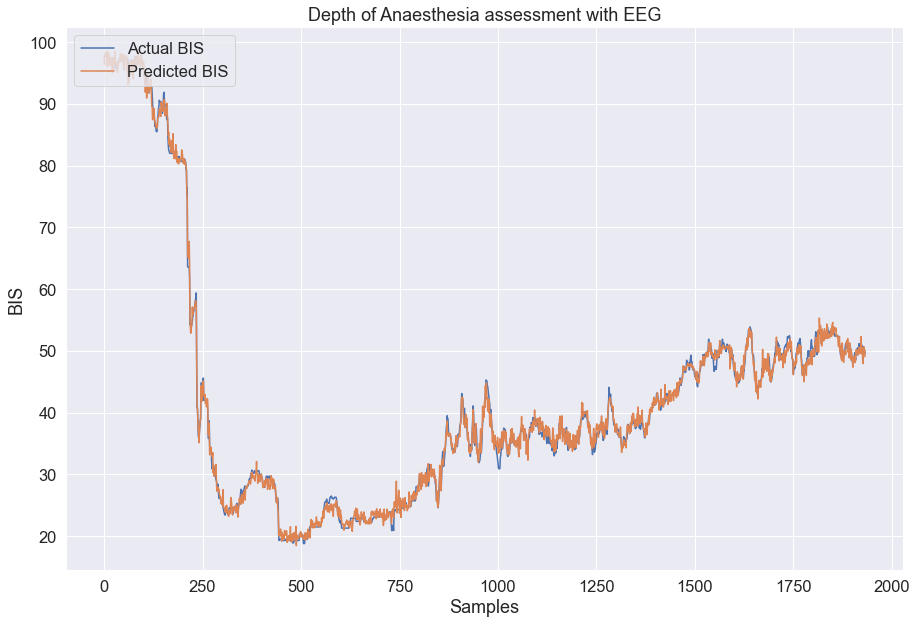

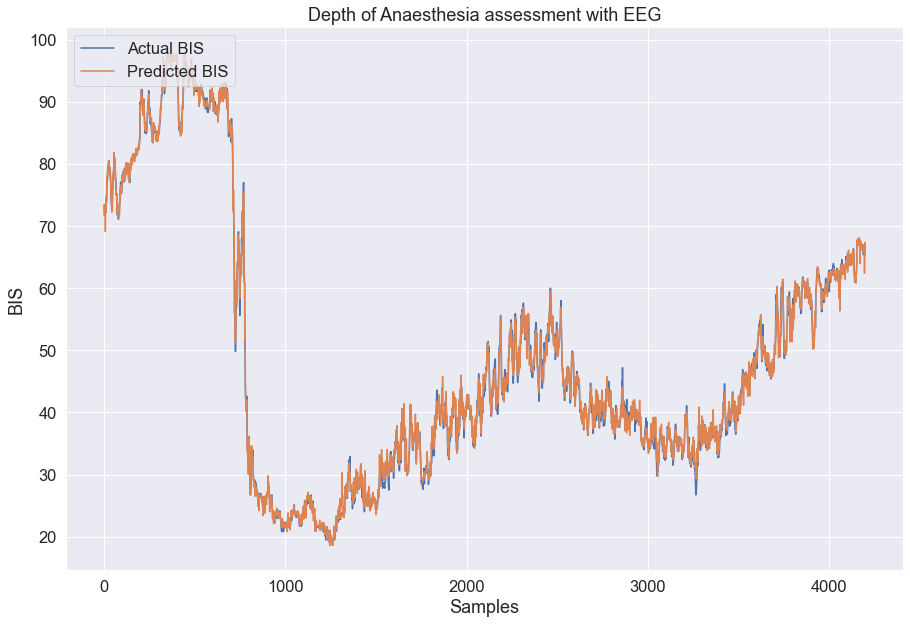

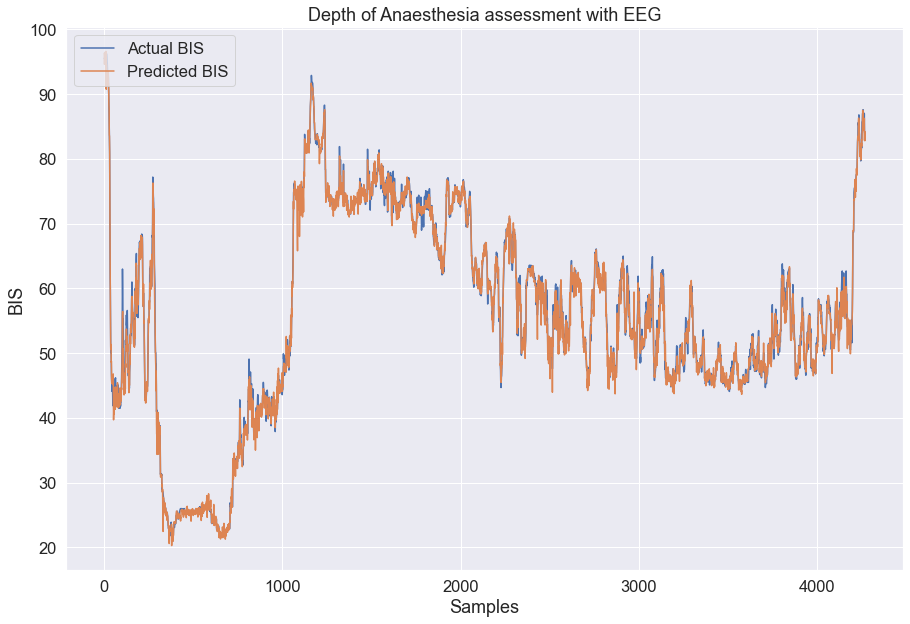

In [124]:
for train in training_set:
    patient = create_dataset(patient=train)
    xg_boost.predict(patient, selected_features, evaluate=False)

<br/>

<br/>

## <code>Histogram-based Gradient boosting tree (Experimental)</code>

In [129]:
hist = model('hist_r', training_df, scale=False)

# Train the model
hist.fit(selected_features)

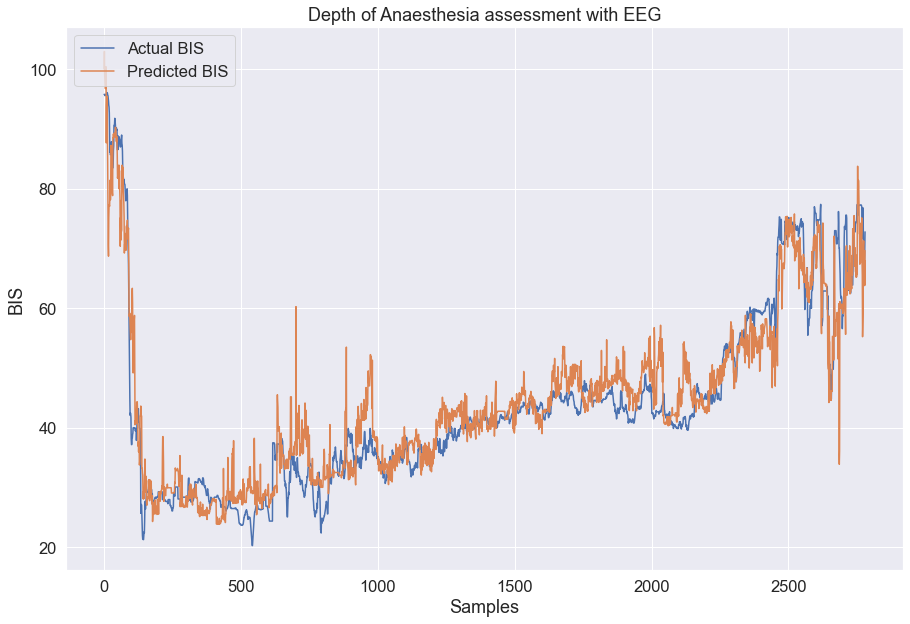

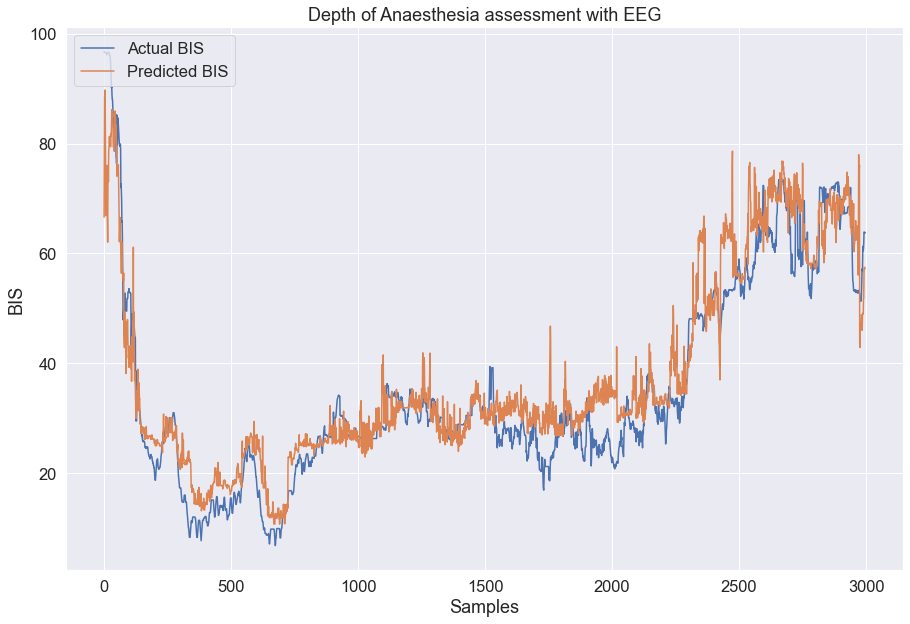

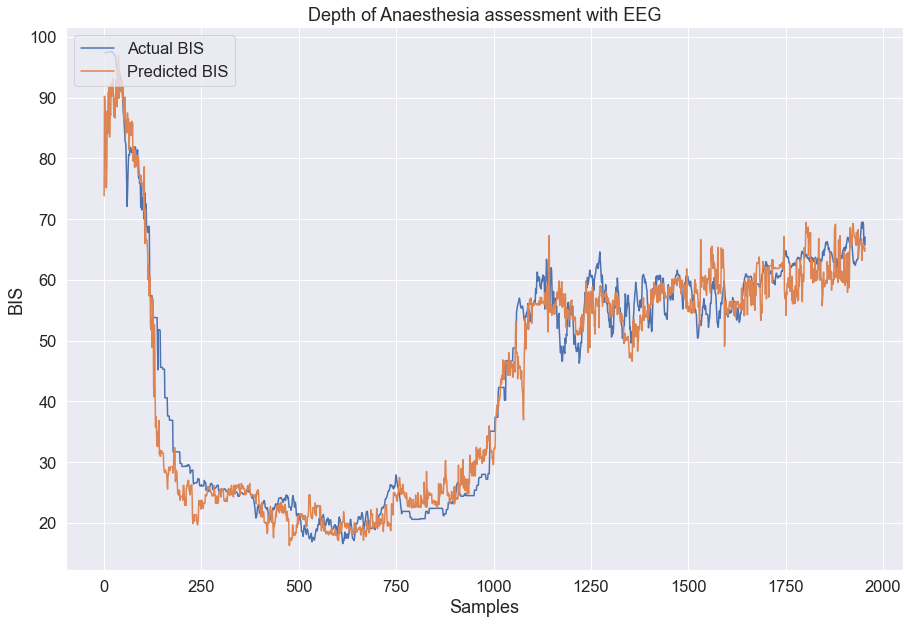

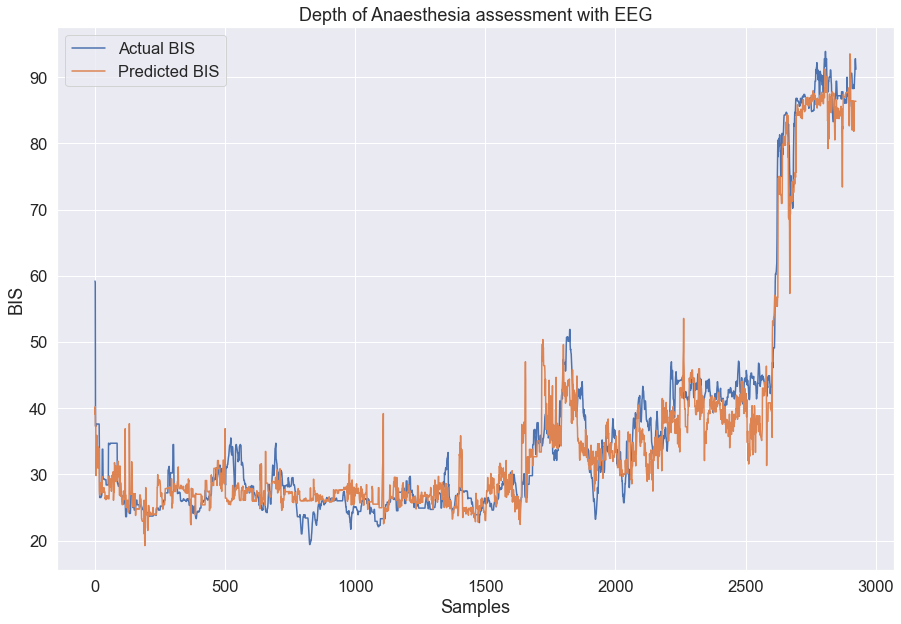

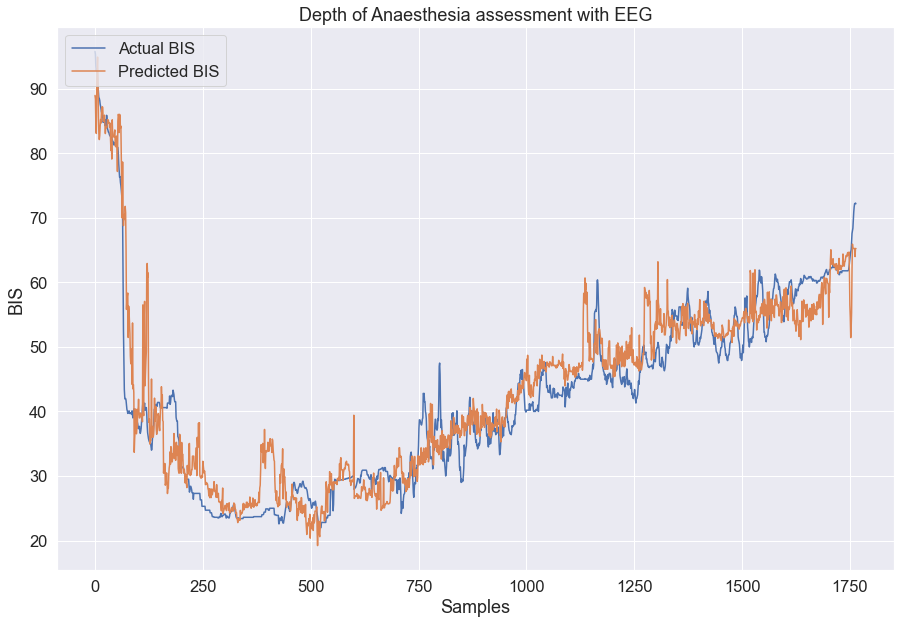

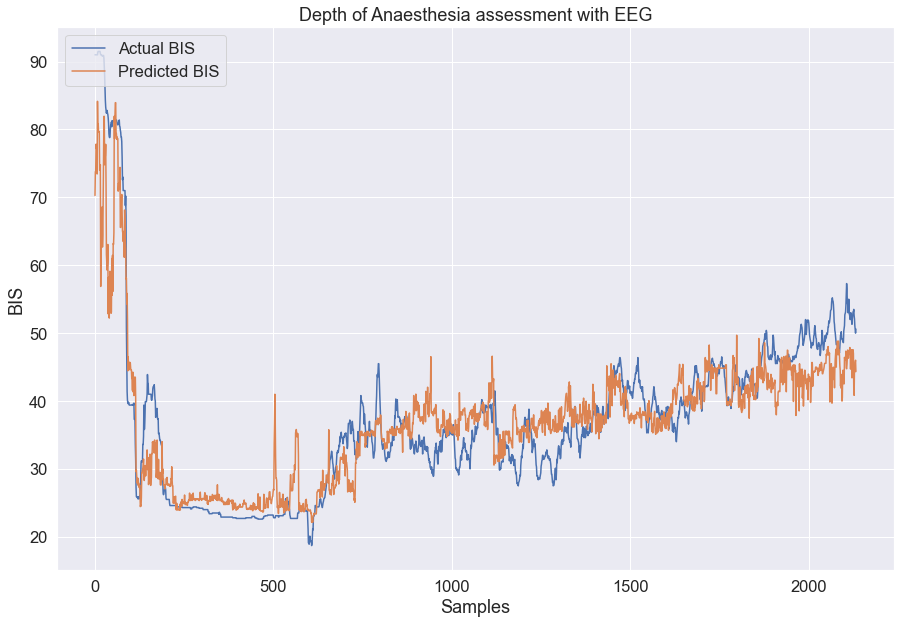

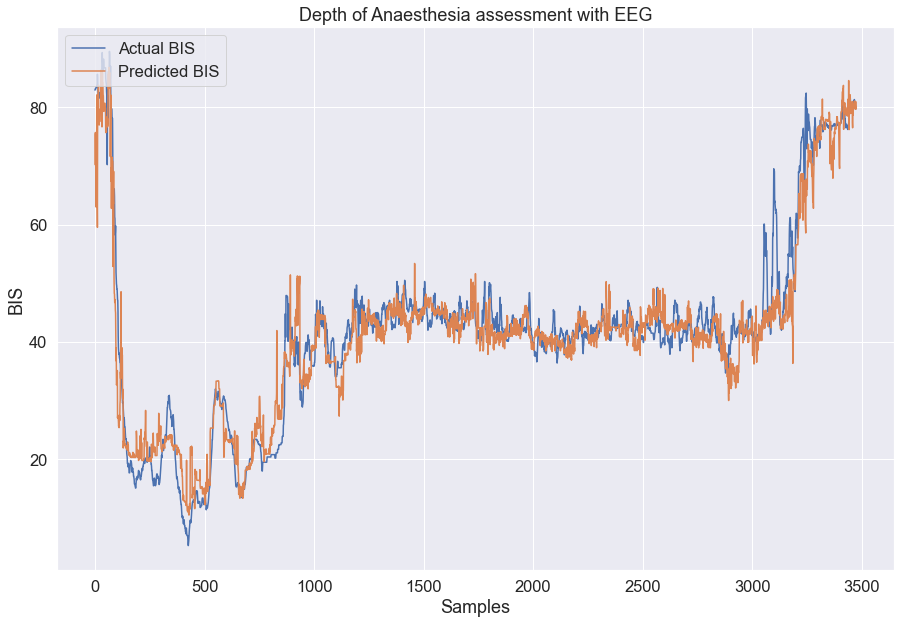

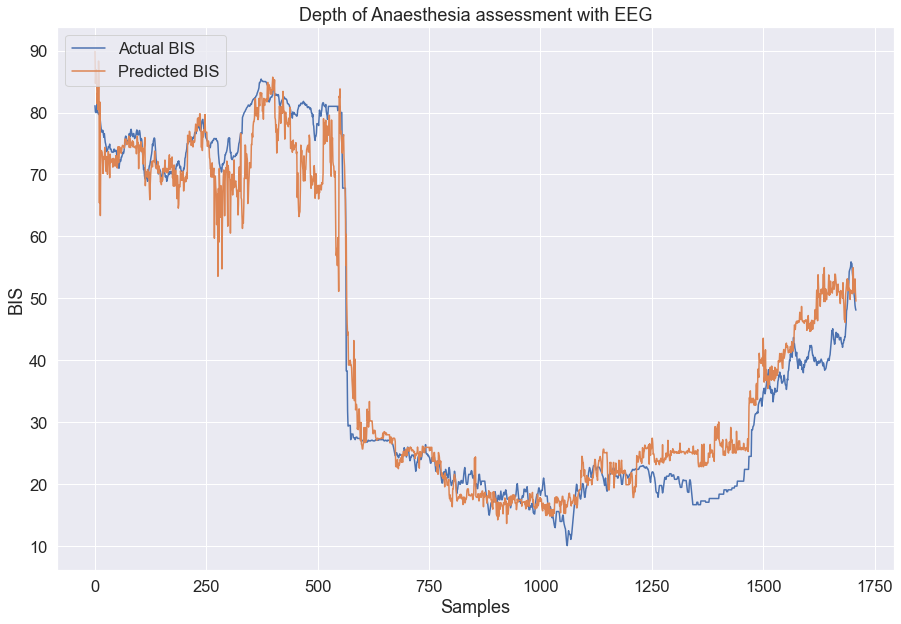

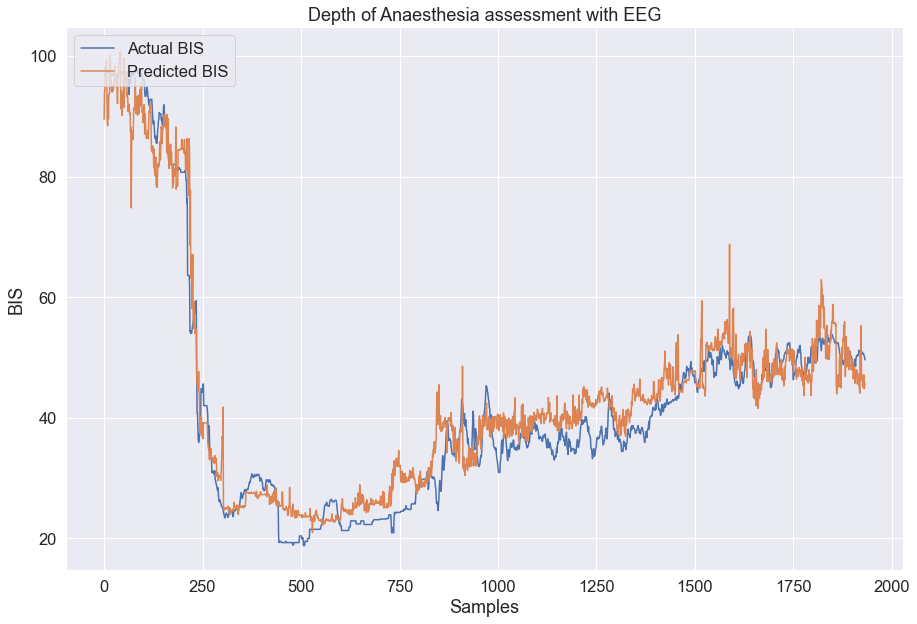

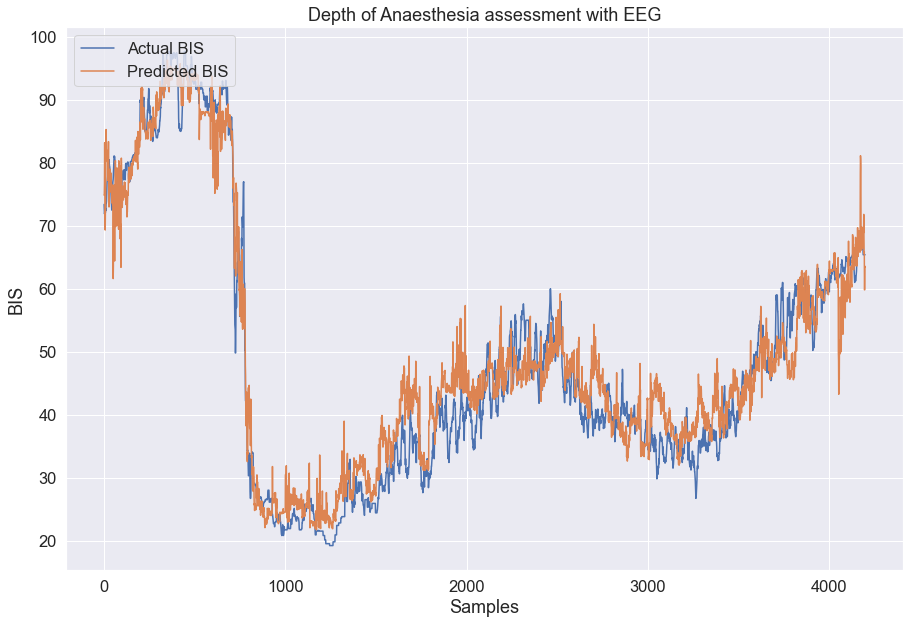

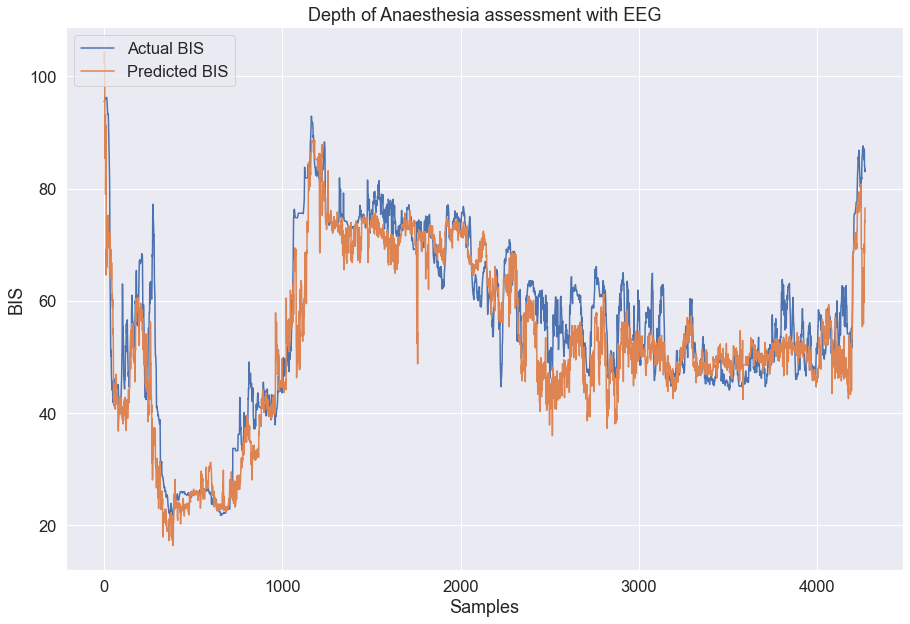

In [130]:
for train in training_set:
    patient = create_dataset(patient=train)
    hist.predict(patient, selected_features, evaluate=False)